# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    #Resize image and transfer to tensor
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])

    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoaders
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

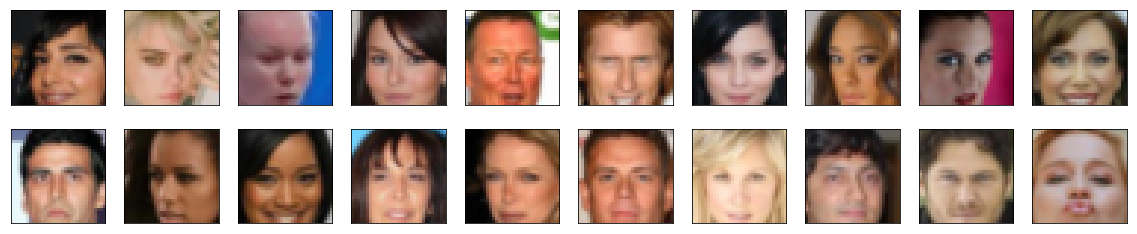

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8353)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
         # complete init function
        self.conv_dim = conv_dim
        
        # complete init function --> input is 32x32x3
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, batch_norm=False)#16x16x32
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, batch_norm=True)#16x16x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, batch_norm=True)#8x8x128
        
        #Classification layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        
        #Flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        #Final layer
        out = self.fc(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, kernel_size=4, batch_norm=True)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4, batch_norm=True)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.

* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    std_dev = 0.02
    mean = 0.0
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        ## Initialize conv and linear layer
        init.normal_(m.weight.data, mean, std_dev)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    #Identify batch size
    batch_size = D_out.size(0)
    
    #Keep it in here
    smooth = True
    
    #Labels
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    #Identify batch_size
    batch_size = D_out.size(0)
    
    # fake labels = 0
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            ####### 1. Train the discriminator on real and fake images
            
            # Real images to discriminator
            D_real = D(real_images)
            
            #Compute real loss
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            
            #Compute fake loss
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss
            d_loss = d_real_loss + d_fake_loss
            
            #Perform backprop
            d_loss.backward()
            d_optimizer.step()

            ####### 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.4803 | g_loss: 0.6890
Epoch [    1/   40] | d_loss: 0.4647 | g_loss: 2.5124
Epoch [    1/   40] | d_loss: 0.4217 | g_loss: 3.2882
Epoch [    1/   40] | d_loss: 0.4747 | g_loss: 2.3187
Epoch [    1/   40] | d_loss: 0.4895 | g_loss: 3.5837
Epoch [    1/   40] | d_loss: 0.5902 | g_loss: 2.7176
Epoch [    1/   40] | d_loss: 0.5308 | g_loss: 3.2151
Epoch [    1/   40] | d_loss: 0.5596 | g_loss: 1.9944
Epoch [    1/   40] | d_loss: 0.5735 | g_loss: 2.0592
Epoch [    1/   40] | d_loss: 0.7384 | g_loss: 2.7554
Epoch [    1/   40] | d_loss: 0.6515 | g_loss: 1.9857
Epoch [    1/   40] | d_loss: 1.0569 | g_loss: 2.7878
Epoch [    1/   40] | d_loss: 0.7103 | g_loss: 2.1179
Epoch [    1/   40] | d_loss: 0.7520 | g_loss: 1.8558
Epoch [    1/   40] | d_loss: 0.8144 | g_loss: 1.9643
Epoch [    1/   40] | d_loss: 0.8689 | g_loss: 1.8051
Epoch [    1/   40] | d_loss: 0.8458 | g_loss: 1.8947
Epoch [    1/   40] | d_loss: 0.8052 | g_loss: 1.6259
Epoch [    1/   40] | d_loss

Epoch [    3/   40] | d_loss: 0.7300 | g_loss: 1.7223
Epoch [    3/   40] | d_loss: 0.8533 | g_loss: 1.0922
Epoch [    3/   40] | d_loss: 0.8415 | g_loss: 1.2652
Epoch [    3/   40] | d_loss: 0.6950 | g_loss: 2.4664
Epoch [    3/   40] | d_loss: 0.9805 | g_loss: 1.2100
Epoch [    3/   40] | d_loss: 0.9386 | g_loss: 0.7580
Epoch [    3/   40] | d_loss: 0.8634 | g_loss: 1.1312
Epoch [    3/   40] | d_loss: 1.0358 | g_loss: 1.0889
Epoch [    3/   40] | d_loss: 1.0897 | g_loss: 1.1499
Epoch [    3/   40] | d_loss: 0.6942 | g_loss: 2.0620
Epoch [    3/   40] | d_loss: 0.8546 | g_loss: 0.9991
Epoch [    3/   40] | d_loss: 0.8850 | g_loss: 1.7117
Epoch [    3/   40] | d_loss: 0.9284 | g_loss: 1.3384
Epoch [    3/   40] | d_loss: 0.7919 | g_loss: 2.3359
Epoch [    3/   40] | d_loss: 0.7304 | g_loss: 1.4311
Epoch [    3/   40] | d_loss: 0.9261 | g_loss: 1.4042
Epoch [    3/   40] | d_loss: 1.0900 | g_loss: 2.1232
Epoch [    3/   40] | d_loss: 0.8391 | g_loss: 1.8126
Epoch [    3/   40] | d_loss

Epoch [    6/   40] | d_loss: 0.7379 | g_loss: 1.9001
Epoch [    6/   40] | d_loss: 0.7780 | g_loss: 1.7553
Epoch [    6/   40] | d_loss: 0.7950 | g_loss: 1.8547
Epoch [    6/   40] | d_loss: 0.5719 | g_loss: 2.3834
Epoch [    6/   40] | d_loss: 0.6534 | g_loss: 1.7522
Epoch [    6/   40] | d_loss: 0.7389 | g_loss: 1.9615
Epoch [    6/   40] | d_loss: 0.6157 | g_loss: 1.6514
Epoch [    6/   40] | d_loss: 0.8715 | g_loss: 2.7317
Epoch [    6/   40] | d_loss: 0.9643 | g_loss: 1.4656
Epoch [    6/   40] | d_loss: 0.7634 | g_loss: 1.8953
Epoch [    6/   40] | d_loss: 0.8416 | g_loss: 2.2196
Epoch [    6/   40] | d_loss: 0.6361 | g_loss: 1.7608
Epoch [    6/   40] | d_loss: 0.9479 | g_loss: 1.5926
Epoch [    6/   40] | d_loss: 0.7835 | g_loss: 1.6152
Epoch [    6/   40] | d_loss: 0.6886 | g_loss: 1.4426
Epoch [    6/   40] | d_loss: 0.6495 | g_loss: 1.9109
Epoch [    6/   40] | d_loss: 0.6525 | g_loss: 1.2714
Epoch [    6/   40] | d_loss: 0.7146 | g_loss: 2.1855
Epoch [    6/   40] | d_loss

Epoch [    9/   40] | d_loss: 0.9155 | g_loss: 1.7186
Epoch [    9/   40] | d_loss: 0.8670 | g_loss: 1.4704
Epoch [    9/   40] | d_loss: 1.3724 | g_loss: 0.8011
Epoch [    9/   40] | d_loss: 0.7557 | g_loss: 2.1700
Epoch [    9/   40] | d_loss: 0.7327 | g_loss: 2.6545
Epoch [    9/   40] | d_loss: 0.7135 | g_loss: 2.1868
Epoch [    9/   40] | d_loss: 0.5058 | g_loss: 2.8448
Epoch [    9/   40] | d_loss: 0.7192 | g_loss: 2.1081
Epoch [    9/   40] | d_loss: 0.6616 | g_loss: 2.2648
Epoch [    9/   40] | d_loss: 0.5592 | g_loss: 1.4076
Epoch [    9/   40] | d_loss: 0.8536 | g_loss: 1.6600
Epoch [    9/   40] | d_loss: 0.8618 | g_loss: 1.5650
Epoch [    9/   40] | d_loss: 0.8419 | g_loss: 1.2800
Epoch [    9/   40] | d_loss: 0.5782 | g_loss: 3.0082
Epoch [    9/   40] | d_loss: 0.6138 | g_loss: 2.4946
Epoch [    9/   40] | d_loss: 0.7169 | g_loss: 1.6965
Epoch [    9/   40] | d_loss: 0.6495 | g_loss: 2.7944
Epoch [    9/   40] | d_loss: 0.5765 | g_loss: 2.4882
Epoch [    9/   40] | d_loss

Epoch [   11/   40] | d_loss: 0.6698 | g_loss: 1.7839
Epoch [   11/   40] | d_loss: 0.6924 | g_loss: 1.6633
Epoch [   11/   40] | d_loss: 0.6505 | g_loss: 2.2835
Epoch [   11/   40] | d_loss: 0.5928 | g_loss: 1.7223
Epoch [   11/   40] | d_loss: 0.8777 | g_loss: 1.6459
Epoch [   11/   40] | d_loss: 0.6637 | g_loss: 1.9432
Epoch [   11/   40] | d_loss: 0.6277 | g_loss: 2.4473
Epoch [   11/   40] | d_loss: 0.6714 | g_loss: 2.2140
Epoch [   11/   40] | d_loss: 0.5219 | g_loss: 2.4916
Epoch [   11/   40] | d_loss: 0.6386 | g_loss: 2.4495
Epoch [   11/   40] | d_loss: 0.5348 | g_loss: 2.5394
Epoch [   11/   40] | d_loss: 0.8494 | g_loss: 1.8406
Epoch [   11/   40] | d_loss: 0.6398 | g_loss: 1.9052
Epoch [   11/   40] | d_loss: 0.8047 | g_loss: 1.9688
Epoch [   11/   40] | d_loss: 0.7045 | g_loss: 2.4249
Epoch [   11/   40] | d_loss: 0.7383 | g_loss: 1.9162
Epoch [   11/   40] | d_loss: 0.6870 | g_loss: 1.7924
Epoch [   11/   40] | d_loss: 0.5811 | g_loss: 2.2687
Epoch [   11/   40] | d_loss

Epoch [   14/   40] | d_loss: 0.5982 | g_loss: 2.0046
Epoch [   14/   40] | d_loss: 0.5415 | g_loss: 3.3574
Epoch [   14/   40] | d_loss: 0.8265 | g_loss: 2.0765
Epoch [   14/   40] | d_loss: 0.7434 | g_loss: 3.7852
Epoch [   14/   40] | d_loss: 0.4941 | g_loss: 2.4871
Epoch [   14/   40] | d_loss: 0.8672 | g_loss: 3.0230
Epoch [   14/   40] | d_loss: 0.4244 | g_loss: 3.4222
Epoch [   14/   40] | d_loss: 0.6246 | g_loss: 2.8422
Epoch [   14/   40] | d_loss: 0.5177 | g_loss: 2.0183
Epoch [   14/   40] | d_loss: 0.5354 | g_loss: 3.5662
Epoch [   14/   40] | d_loss: 0.5227 | g_loss: 2.1989
Epoch [   14/   40] | d_loss: 0.7238 | g_loss: 1.6599
Epoch [   14/   40] | d_loss: 0.5120 | g_loss: 3.1291
Epoch [   14/   40] | d_loss: 0.6615 | g_loss: 3.2822
Epoch [   14/   40] | d_loss: 0.4998 | g_loss: 1.8846
Epoch [   14/   40] | d_loss: 0.7532 | g_loss: 2.2047
Epoch [   14/   40] | d_loss: 0.7541 | g_loss: 1.9459
Epoch [   14/   40] | d_loss: 0.5957 | g_loss: 2.0878
Epoch [   14/   40] | d_loss

Epoch [   17/   40] | d_loss: 0.6420 | g_loss: 2.2621
Epoch [   17/   40] | d_loss: 0.5229 | g_loss: 2.1893
Epoch [   17/   40] | d_loss: 1.1247 | g_loss: 3.7465
Epoch [   17/   40] | d_loss: 0.9141 | g_loss: 2.0489
Epoch [   17/   40] | d_loss: 0.7228 | g_loss: 3.0902
Epoch [   17/   40] | d_loss: 0.6414 | g_loss: 3.2697
Epoch [   17/   40] | d_loss: 0.5220 | g_loss: 2.5557
Epoch [   17/   40] | d_loss: 0.5763 | g_loss: 2.5613
Epoch [   17/   40] | d_loss: 0.5369 | g_loss: 2.6676
Epoch [   17/   40] | d_loss: 0.4930 | g_loss: 2.5043
Epoch [   17/   40] | d_loss: 0.7285 | g_loss: 2.2356
Epoch [   17/   40] | d_loss: 0.5000 | g_loss: 3.0231
Epoch [   17/   40] | d_loss: 0.5237 | g_loss: 2.8624
Epoch [   17/   40] | d_loss: 0.6999 | g_loss: 2.0661
Epoch [   17/   40] | d_loss: 0.6011 | g_loss: 3.2052
Epoch [   17/   40] | d_loss: 0.5470 | g_loss: 3.5513
Epoch [   17/   40] | d_loss: 0.5468 | g_loss: 2.7336
Epoch [   17/   40] | d_loss: 0.4798 | g_loss: 3.2135
Epoch [   17/   40] | d_loss

Epoch [   19/   40] | d_loss: 0.5426 | g_loss: 2.4350
Epoch [   19/   40] | d_loss: 0.6910 | g_loss: 2.1086
Epoch [   19/   40] | d_loss: 0.6161 | g_loss: 2.1345
Epoch [   19/   40] | d_loss: 0.9290 | g_loss: 2.5026
Epoch [   19/   40] | d_loss: 0.4814 | g_loss: 2.4611
Epoch [   19/   40] | d_loss: 0.5940 | g_loss: 1.5867
Epoch [   19/   40] | d_loss: 0.4178 | g_loss: 3.1077
Epoch [   19/   40] | d_loss: 0.6539 | g_loss: 3.0790
Epoch [   19/   40] | d_loss: 0.6041 | g_loss: 3.3418
Epoch [   19/   40] | d_loss: 0.6268 | g_loss: 2.9582
Epoch [   19/   40] | d_loss: 0.7716 | g_loss: 1.7114
Epoch [   19/   40] | d_loss: 0.6077 | g_loss: 2.5745
Epoch [   19/   40] | d_loss: 0.6389 | g_loss: 3.0010
Epoch [   19/   40] | d_loss: 0.6198 | g_loss: 2.3269
Epoch [   19/   40] | d_loss: 0.6100 | g_loss: 3.5609
Epoch [   19/   40] | d_loss: 0.5391 | g_loss: 1.8215
Epoch [   19/   40] | d_loss: 0.5307 | g_loss: 2.3031
Epoch [   19/   40] | d_loss: 0.4512 | g_loss: 3.0816
Epoch [   19/   40] | d_loss

Epoch [   22/   40] | d_loss: 0.4297 | g_loss: 2.8971
Epoch [   22/   40] | d_loss: 0.5179 | g_loss: 2.8756
Epoch [   22/   40] | d_loss: 0.4975 | g_loss: 3.3955
Epoch [   22/   40] | d_loss: 0.5162 | g_loss: 2.3801
Epoch [   22/   40] | d_loss: 0.4744 | g_loss: 2.9929
Epoch [   22/   40] | d_loss: 0.7711 | g_loss: 2.3866
Epoch [   22/   40] | d_loss: 0.7030 | g_loss: 3.2434
Epoch [   22/   40] | d_loss: 0.4807 | g_loss: 2.5809
Epoch [   22/   40] | d_loss: 0.5053 | g_loss: 4.1183
Epoch [   22/   40] | d_loss: 0.4269 | g_loss: 3.4707
Epoch [   22/   40] | d_loss: 0.4724 | g_loss: 3.5740
Epoch [   22/   40] | d_loss: 0.5937 | g_loss: 3.5257
Epoch [   22/   40] | d_loss: 0.6264 | g_loss: 1.8831
Epoch [   22/   40] | d_loss: 0.4977 | g_loss: 2.3927
Epoch [   22/   40] | d_loss: 0.4987 | g_loss: 2.6416
Epoch [   22/   40] | d_loss: 0.6645 | g_loss: 2.1515
Epoch [   22/   40] | d_loss: 0.5118 | g_loss: 2.9841
Epoch [   22/   40] | d_loss: 0.5082 | g_loss: 3.3650
Epoch [   22/   40] | d_loss

Epoch [   25/   40] | d_loss: 0.4789 | g_loss: 4.4872
Epoch [   25/   40] | d_loss: 0.6356 | g_loss: 3.2586
Epoch [   25/   40] | d_loss: 0.4619 | g_loss: 3.6664
Epoch [   25/   40] | d_loss: 0.4361 | g_loss: 3.9942
Epoch [   25/   40] | d_loss: 0.5035 | g_loss: 2.6833
Epoch [   25/   40] | d_loss: 0.4049 | g_loss: 4.0661
Epoch [   25/   40] | d_loss: 0.4962 | g_loss: 2.7235
Epoch [   25/   40] | d_loss: 0.6921 | g_loss: 2.7410
Epoch [   25/   40] | d_loss: 0.3947 | g_loss: 3.2335
Epoch [   25/   40] | d_loss: 0.4130 | g_loss: 3.5675
Epoch [   25/   40] | d_loss: 0.5055 | g_loss: 2.5904
Epoch [   25/   40] | d_loss: 0.4656 | g_loss: 3.6472
Epoch [   25/   40] | d_loss: 0.4781 | g_loss: 3.1684
Epoch [   25/   40] | d_loss: 0.6019 | g_loss: 2.5144
Epoch [   25/   40] | d_loss: 0.4459 | g_loss: 3.0352
Epoch [   25/   40] | d_loss: 0.6098 | g_loss: 2.6829
Epoch [   25/   40] | d_loss: 0.5158 | g_loss: 2.9551
Epoch [   25/   40] | d_loss: 0.6689 | g_loss: 2.5539
Epoch [   25/   40] | d_loss

Epoch [   27/   40] | d_loss: 0.5380 | g_loss: 1.8364
Epoch [   27/   40] | d_loss: 0.6062 | g_loss: 2.4822
Epoch [   27/   40] | d_loss: 0.5059 | g_loss: 3.1289
Epoch [   27/   40] | d_loss: 0.5800 | g_loss: 2.7831
Epoch [   27/   40] | d_loss: 0.4986 | g_loss: 3.1904
Epoch [   27/   40] | d_loss: 0.4518 | g_loss: 3.8994
Epoch [   27/   40] | d_loss: 0.6649 | g_loss: 2.3537
Epoch [   27/   40] | d_loss: 0.8742 | g_loss: 4.3871
Epoch [   27/   40] | d_loss: 0.7577 | g_loss: 2.8452
Epoch [   27/   40] | d_loss: 0.6772 | g_loss: 2.6544
Epoch [   27/   40] | d_loss: 0.4375 | g_loss: 3.8157
Epoch [   27/   40] | d_loss: 0.5674 | g_loss: 2.5796
Epoch [   27/   40] | d_loss: 0.5144 | g_loss: 3.1354
Epoch [   27/   40] | d_loss: 0.4287 | g_loss: 3.8197
Epoch [   27/   40] | d_loss: 0.4547 | g_loss: 3.8792
Epoch [   27/   40] | d_loss: 0.4748 | g_loss: 3.4088
Epoch [   27/   40] | d_loss: 0.7234 | g_loss: 1.9857
Epoch [   27/   40] | d_loss: 0.4732 | g_loss: 2.6986
Epoch [   27/   40] | d_loss

Epoch [   30/   40] | d_loss: 0.5178 | g_loss: 2.5394
Epoch [   30/   40] | d_loss: 0.5554 | g_loss: 3.6355
Epoch [   30/   40] | d_loss: 0.5909 | g_loss: 2.3401
Epoch [   30/   40] | d_loss: 0.4067 | g_loss: 4.0433
Epoch [   30/   40] | d_loss: 0.5161 | g_loss: 2.7339
Epoch [   30/   40] | d_loss: 0.6789 | g_loss: 0.9812
Epoch [   30/   40] | d_loss: 0.4543 | g_loss: 3.1204
Epoch [   30/   40] | d_loss: 0.4196 | g_loss: 3.3697
Epoch [   30/   40] | d_loss: 0.5265 | g_loss: 3.2311
Epoch [   30/   40] | d_loss: 0.6103 | g_loss: 2.8304
Epoch [   30/   40] | d_loss: 0.4191 | g_loss: 3.5679
Epoch [   30/   40] | d_loss: 0.5137 | g_loss: 3.2588
Epoch [   30/   40] | d_loss: 0.4260 | g_loss: 3.3330
Epoch [   30/   40] | d_loss: 0.5192 | g_loss: 3.4311
Epoch [   30/   40] | d_loss: 0.4327 | g_loss: 3.4420
Epoch [   30/   40] | d_loss: 0.4778 | g_loss: 3.8486
Epoch [   30/   40] | d_loss: 0.6030 | g_loss: 2.2012
Epoch [   30/   40] | d_loss: 0.4576 | g_loss: 2.3289
Epoch [   30/   40] | d_loss

Epoch [   33/   40] | d_loss: 0.5501 | g_loss: 2.3707
Epoch [   33/   40] | d_loss: 0.4488 | g_loss: 2.6921
Epoch [   33/   40] | d_loss: 0.7893 | g_loss: 3.4989
Epoch [   33/   40] | d_loss: 0.4684 | g_loss: 2.9499
Epoch [   33/   40] | d_loss: 0.4227 | g_loss: 3.8776
Epoch [   33/   40] | d_loss: 0.4880 | g_loss: 3.6125
Epoch [   33/   40] | d_loss: 0.6898 | g_loss: 2.0835
Epoch [   33/   40] | d_loss: 0.4734 | g_loss: 3.1407
Epoch [   33/   40] | d_loss: 0.3962 | g_loss: 3.6492
Epoch [   33/   40] | d_loss: 0.5120 | g_loss: 3.3221
Epoch [   33/   40] | d_loss: 0.4713 | g_loss: 3.5765
Epoch [   33/   40] | d_loss: 0.9780 | g_loss: 1.7546
Epoch [   33/   40] | d_loss: 0.4865 | g_loss: 3.5543
Epoch [   33/   40] | d_loss: 0.4736 | g_loss: 2.9278
Epoch [   33/   40] | d_loss: 0.5443 | g_loss: 2.5456
Epoch [   33/   40] | d_loss: 0.8411 | g_loss: 3.2000
Epoch [   33/   40] | d_loss: 0.4405 | g_loss: 3.3151
Epoch [   33/   40] | d_loss: 0.4400 | g_loss: 3.4877
Epoch [   33/   40] | d_loss

Epoch [   35/   40] | d_loss: 0.4825 | g_loss: 2.4493
Epoch [   35/   40] | d_loss: 0.5707 | g_loss: 3.7836
Epoch [   35/   40] | d_loss: 0.5684 | g_loss: 2.6113
Epoch [   35/   40] | d_loss: 0.4369 | g_loss: 3.1543
Epoch [   35/   40] | d_loss: 0.5729 | g_loss: 2.6009
Epoch [   35/   40] | d_loss: 0.4876 | g_loss: 3.2314
Epoch [   35/   40] | d_loss: 0.5536 | g_loss: 2.8971
Epoch [   35/   40] | d_loss: 0.5859 | g_loss: 1.8184
Epoch [   35/   40] | d_loss: 0.4890 | g_loss: 3.2067
Epoch [   35/   40] | d_loss: 0.6272 | g_loss: 2.8425
Epoch [   35/   40] | d_loss: 0.4172 | g_loss: 3.5895
Epoch [   35/   40] | d_loss: 0.6507 | g_loss: 2.9806
Epoch [   35/   40] | d_loss: 0.5054 | g_loss: 3.5733
Epoch [   35/   40] | d_loss: 0.4168 | g_loss: 4.4006
Epoch [   35/   40] | d_loss: 0.4811 | g_loss: 3.6350
Epoch [   35/   40] | d_loss: 0.5480 | g_loss: 2.3250
Epoch [   35/   40] | d_loss: 0.6357 | g_loss: 1.5707
Epoch [   35/   40] | d_loss: 0.4145 | g_loss: 3.0583
Epoch [   35/   40] | d_loss

Epoch [   38/   40] | d_loss: 0.5942 | g_loss: 3.0973
Epoch [   38/   40] | d_loss: 0.6032 | g_loss: 3.4723
Epoch [   38/   40] | d_loss: 0.4112 | g_loss: 4.5151
Epoch [   38/   40] | d_loss: 0.5039 | g_loss: 3.4698
Epoch [   38/   40] | d_loss: 0.6014 | g_loss: 2.7846
Epoch [   38/   40] | d_loss: 0.7643 | g_loss: 2.7493
Epoch [   38/   40] | d_loss: 0.6690 | g_loss: 3.2373
Epoch [   38/   40] | d_loss: 0.6344 | g_loss: 2.7374
Epoch [   38/   40] | d_loss: 0.4784 | g_loss: 3.0559
Epoch [   38/   40] | d_loss: 0.8970 | g_loss: 2.2083
Epoch [   38/   40] | d_loss: 0.4393 | g_loss: 3.4143
Epoch [   38/   40] | d_loss: 0.4901 | g_loss: 3.0101
Epoch [   38/   40] | d_loss: 0.6742 | g_loss: 3.0494
Epoch [   38/   40] | d_loss: 0.4997 | g_loss: 3.5131
Epoch [   38/   40] | d_loss: 0.5855 | g_loss: 2.5567
Epoch [   38/   40] | d_loss: 0.5049 | g_loss: 3.9060
Epoch [   38/   40] | d_loss: 0.5567 | g_loss: 2.4711
Epoch [   38/   40] | d_loss: 0.6957 | g_loss: 2.3152
Epoch [   38/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

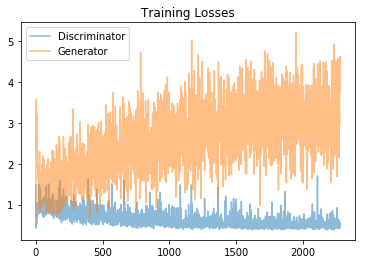

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

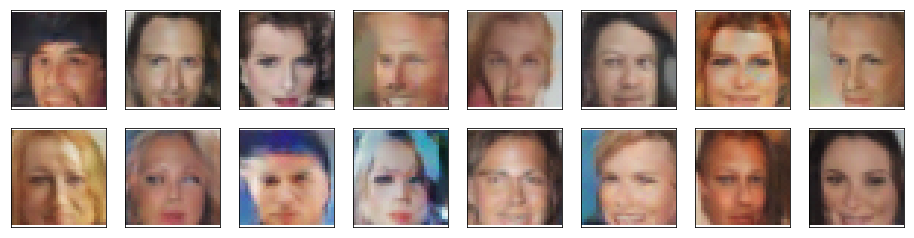

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

* The dataset is biased in that it mainly contains white faces. To improve on that we need to include more diverse pictures in the sample set. 
* The model used is fairly small. In order to learn more features it is likely that we would require a larger model. This would potentially inrease training time. 
* In our case we did not optimize the hyperparameters yet. Based on the loss graph it seems like we have not yet reached a plateau level. This means that by increasing training (epochs) we could potentially increase our results by learning new features. In addition, other hyperparameters could be fine-tuned to acchieve better results. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.